# Time Series Analysis for SuperMarket Sales Forcasting using ARIMA and Prophet Model



Time series are one of the most common data types encountered in daily life. The SuperStore data are collected at 3 years intervals. In this project, I deal with the time series dataset using ARIMA and Prophet in python. 


## Requirements

- Python
- sklearn
- Numpy 
- Pandas
- Matplotlib
- Statsmodels
- fbprophet 

## Dataset

The Dataset is about Superstore sales, and csv file downloadable by clicking hear: https://raw.githubusercontent.com/curran/data/gh-pages/superstoreSales/superstoreSales.csv

## Exploratory Data Analysis

First we use pandas to read the CSV file. After that I perform Data Cleaning such as removing unwanted columns, identifying and filling the missing values.

### Describetive data

- Load time series data from csv online file
- View basic information on the data
- Quickly explore distributions and relationships in a dataset via plots.

It looks like we have integer, float, and object (categorical) features. Also, 63 missing values for profit. For this project, profit is not our target variable. let's ignore missing value in the dataset.



In [61]:
import io
import pandas as pd
import requests
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import ensemble, metrics
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score#R square
from sklearn.metrics import mean_squared_error

url = "https://raw.githubusercontent.com/curran/data/gh-pages/superstoreSales/superstoreSales.csv"
data = pd.read_csv(url,encoding ='latin1')

In [62]:
# Data information
data.info()

# Check the number of null in the dataset
data['Product Base Margin'].isnull().sum()
# data=data[data["Product Base Margin"].notnull()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8399 entries, 0 to 8398
Data columns (total 21 columns):
Row ID                  8399 non-null int64
Order ID                8399 non-null int64
Order Date              8399 non-null object
Order Priority          8399 non-null object
Order Quantity          8399 non-null int64
Sales                   8399 non-null float64
Discount                8399 non-null float64
Ship Mode               8399 non-null object
Profit                  8399 non-null float64
Unit Price              8399 non-null float64
Shipping Cost           8399 non-null float64
Customer Name           8399 non-null object
Province                8399 non-null object
Region                  8399 non-null object
Customer Segment        8399 non-null object
Product Category        8399 non-null object
Product Sub-Category    8399 non-null object
Product Name            8399 non-null object
Product Container       8399 non-null object
Product Base Margin     8336 non-nul

63

There are a few categories in the superstore sales data. Here I need to summarie the number and give the reference information for next step analysis. And I change the data type for Order Date and Ship Date from object to datetime. 

In [63]:

cat = data.select_dtypes(include=['object'])
header = list(cat)
a =['Order Date','Ship Date']
for i in a:
    # switch the data type of date.
    data[i]= data[i].transform(lambda x: datetime.strptime(x, '%m/%d/%Y'))
for i in header:
    if i not in a:
        print(data[i].value_counts())
    

High             1768
Low              1720
Not Specified    1672
Medium           1631
Critical         1608
Name: Order Priority, dtype: int64
Regular Air       6270
Delivery Truck    1146
Express Air        983
Name: Ship Mode, dtype: int64
Darren Budd           41
Ed Braxton            38
Brad Thomas           35
Carlos Soltero        33
Patrick Jones         30
Tony Sayre            29
Giulietta Dortch      28
Lena Creighton        28
Joy Smith             28
Mark Cousins          28
Nora Price            28
Jack O'Briant         28
Grant Carroll         27
Eric Barreto          27
Sally Knutson         27
Adam Hart             27
Alan Hwang            27
Denise Monton         27
Sonia Sunley          26
Christy Brittain      26
Harold Dahlen         26
Roy Skaria            26
Quincy Jones          25
Bill Donatelli        25
Maria Bertelson       25
Cynthia Arntzen       25
Edward Nazzal         24
Sylvia Foulston       24
Lauren Leatherbury    24
Pauline Chand         24
      

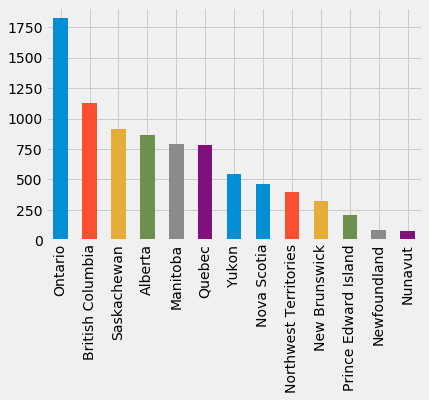

In [64]:
data['Province'].value_counts().plot.bar()

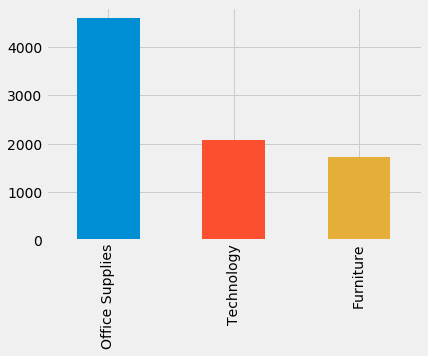

In [65]:
data['Product Category'].value_counts().plot.bar()

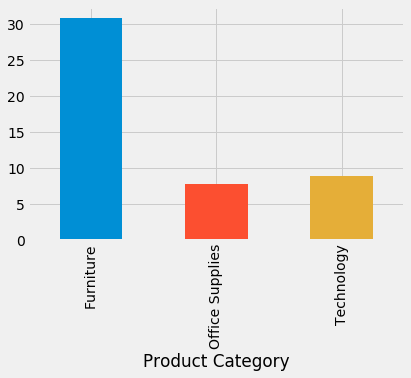

In [66]:
data.groupby('Product Category')['Shipping Cost'].mean().plot.bar()

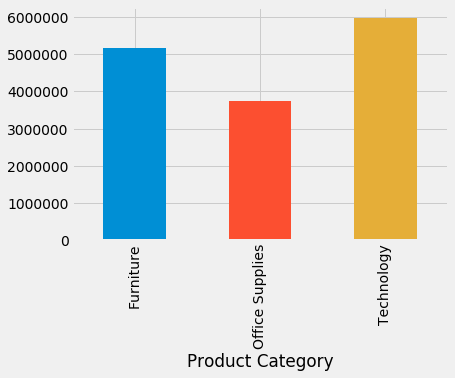

In [67]:
data.groupby('Product Category')['Sales'].sum().plot.bar()

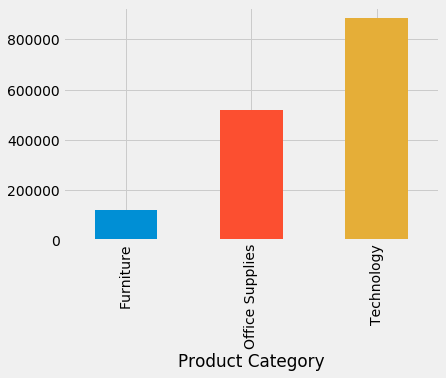

In [68]:
data.groupby('Product Category')['Profit'].sum().plot.bar()

In [69]:
data['Order Date'].max()-data['Order Date'].min()

Timedelta('1459 days 00:00:00')

Here we have 4 year sales data for 3 types of product category. And plots show some interesting distributions on different categories. 


### Data Preprocessing

This step, I perform data cleaning such removing unwanted columns, identifying the missing values, and aggregate sales or profit under different product category by date. 

In [70]:
furniture = data.loc[data['Product Category'] == 'Furniture']
technology = data.loc[data['Product Category'] == 'Technology']
office = data.loc[data['Product Category'] == 'Office Supplies']
l =[furniture, technology, office]

In [71]:
furniture.isnull().sum()
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
furniture = furniture['Sales'].resample('MS').mean()
furniture
tech = technology.groupby('Order Date')['Sales'].sum().reset_index()
tech = tech.set_index('Order Date')
tech = tech['Sales'].resample('MS').mean()


In [72]:
ts=[]
for i in l:
    i = i.groupby('Order Date')['Sales'].sum().reset_index()
    i = i.set_index('Order Date')
    temp = i['Sales'].resample('MS').mean()
    temp = pd.DataFrame({'Order Date':temp.index, 'Sales':temp.values})
    ts.append(temp)
store = ts[0].merge(ts[1], how='inner', on='Order Date')
store=store.merge(ts[2],how='inner',on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'technology_sales','Sales':'office_sales'}, inplace=True)


ts_profit=[]
for i in l:
    i = i.groupby('Order Date')['Profit'].sum().reset_index()
    i = i.set_index('Order Date')
    temp = i['Profit'].resample('MS').mean()
    temp = pd.DataFrame({'Order Date':temp.index, 'Profit':temp.values})
    ts_profit.append(temp)
store_profit = ts_profit[0].merge(ts_profit[1], how='inner', on='Order Date')
store_profit=store_profit.merge(ts_profit[2],how='inner',on='Order Date')

store_profit.rename(columns={'Profit_x': 'furniture_profit', 'Profit_y': 'technology_profit','Profit':'office_profit'}, inplace=True)


### Time Series of sales for Furniture, Technology and Office supplies

Combine furniture, technology and office sales datas in the same time period and dig some information about the seasonal pattern on different categories from time series plots. 

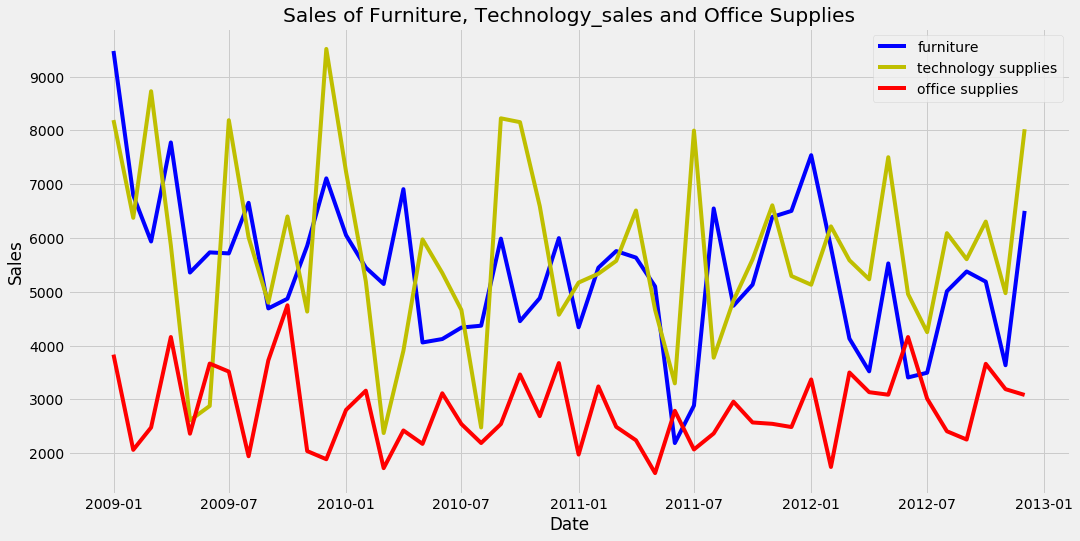

In [73]:
from matplotlib import style
style.use('fivethirtyeight')
plt.figure(figsize=(16, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['technology_sales'], 'y-', label = 'technology supplies')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture, Technology_sales and Office Supplies')
plt.legend();

Check the seasonal pattern for sales of furniture, technology and office supplies. 

### Visualizing Furniture Sales and Profit Time Series Data

Text(0.5,1,'furniture_profit')

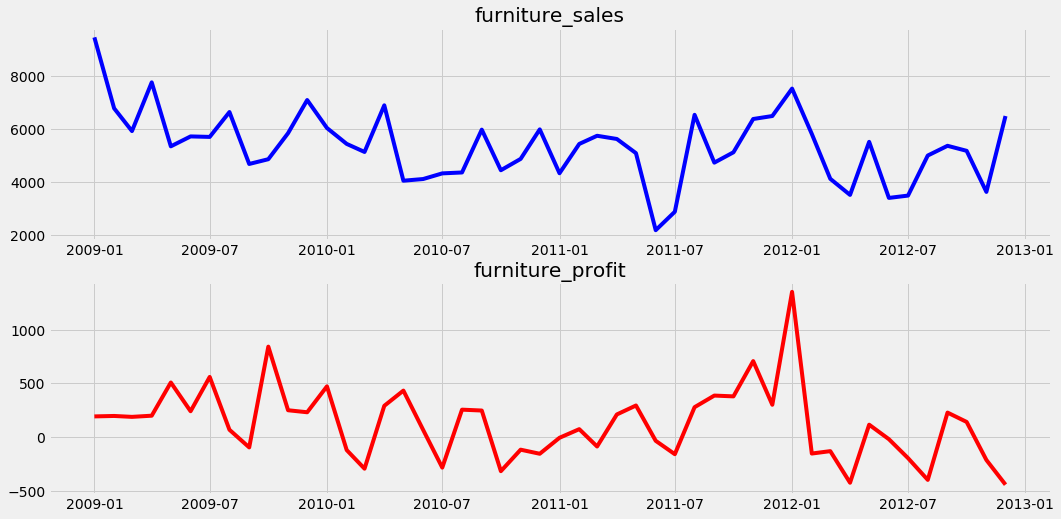

In [74]:
from matplotlib import style
style.use('fivethirtyeight')
fig=plt.figure(figsize=(16, 8))
a1=fig.add_subplot(211)
a2=fig.add_subplot(212)

a1.plot(store['Order Date'], store['furniture_sales'],'b-')
a1.set_title('furniture_sales')
a2.plot(store_profit['Order Date'], store_profit['furniture_profit'],'r-')
a2.set_title('furniture_profit')



## ARMA prediction model for Furniture time series data.

ARIMA stands for Auto Regressive Integrated Moving Average. ARIMA is a simple stochastic time series model that we can use to train and then forecast future time points. ARIMA can capture complex relationships as it takes error terms and observations of lagged terms. These models rely on regressing a variable on past values.

And keep in minds that ARMA model is based on a number of assumptions which includes that Time series is stationary. 

In [75]:
import statsmodels.api as sm
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(furniture,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
    

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:943.5008920313053


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:904.3269739231632
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:608.9667436447883
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:625.0781111486424


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1158.2548171788078
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:420.0699617071805
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:895.8127560446968
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3817.1462437249243
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:593.2949727247997
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:626.8969427700782
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3478.671517366012
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:422.0847868912542
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:802.5378233154462


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:901.0771823354005
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:611.5693237116368
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:614.0641715450669


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1167.3950905907864
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:416.2554269117501
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:774.3278333780047
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2811.0076073504047
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:578.7441597182022
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:600.8052675585079
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2659.5894274423295
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:402.32104545337074
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:822.4217789454324
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1488.8680325143664
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:609.9811283929618
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:607.3136920627983


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1189.0419647097826
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:400.84749740684094
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:793.5799459373715
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:396581071.85179204
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:595.1884130016799
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:604.8874594477727
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:402.14677457153965
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:800.1745813954376


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:727.3254321012655
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:606.5709046433309
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:595.013370315939
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1211.2961154728423
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:394.53003880025665
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:775.4394526771239
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:96460.75484679587
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:579.1225660949439
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:585.1735604147607
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2600.9914485843397
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:387.5514485708235


According to the result: ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:387.5514485708235, ARIMA(1, 1, 1)x(1, 1, 0, 12) could be the parameter.

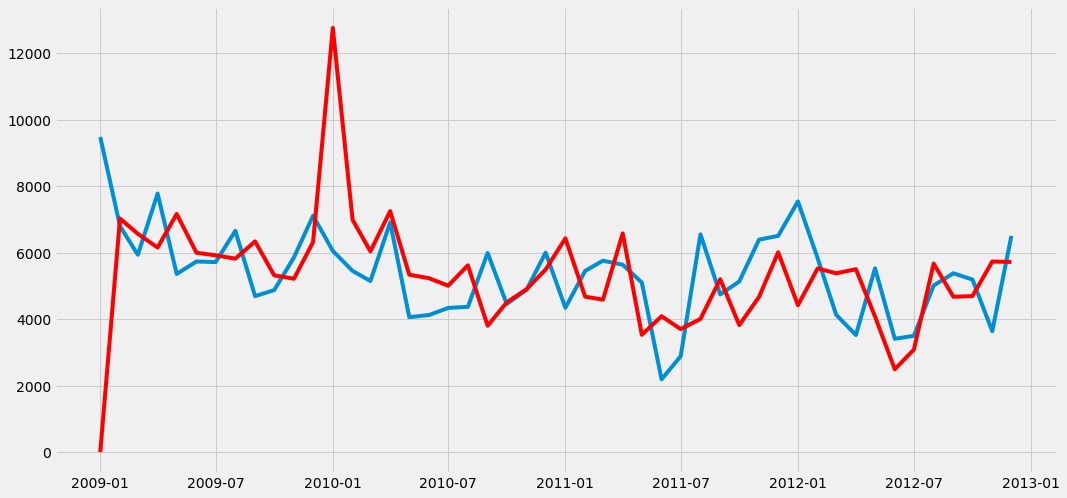

In [76]:


model = sm.tsa.statespace.SARIMAX(furniture,order=(1,1,1),seasonal_order=(1,1,0,12),nforce_stationarity=False,
                                enforce_invertibility=False)
results=model.fit()
plt.figure(figsize=(16, 8))
plt.plot(furniture)
plt.plot(results.fittedvalues,color='red')
plt.show()

In [77]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1271      0.182      0.699      0.484      -0.229       0.483
ma.L1         -1.0298      0.222     -4.647      0.000      -1.464      -0.596
ar.S.L12      -0.2855      0.142     -2.015      0.044      -0.563      -0.008
sigma2      1.466e+06   5.89e+05      2.490      0.013    3.12e+05    2.62e+06


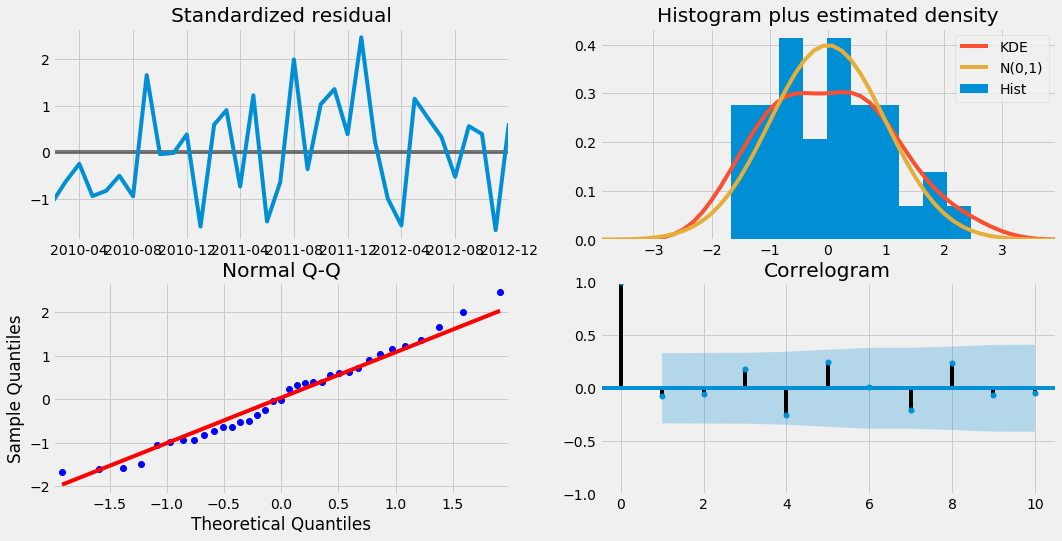

In [78]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

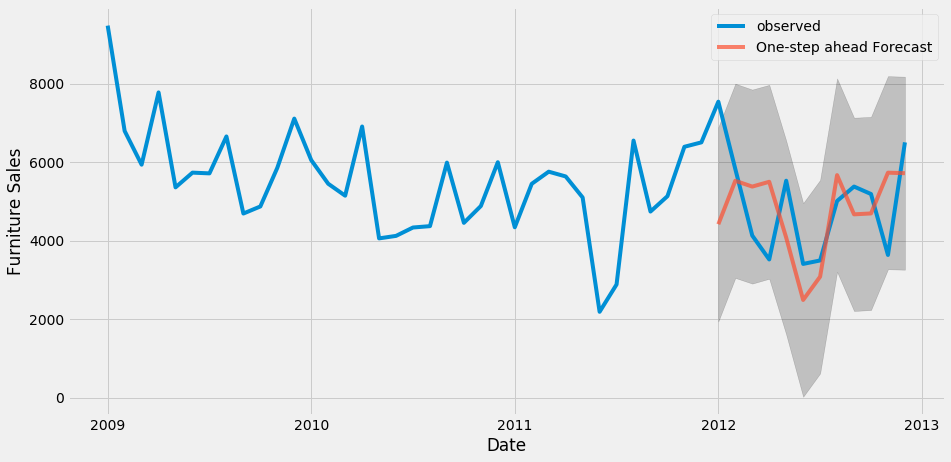

In [79]:
pred = results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = furniture['2009':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Evaluate the prediction results based on ARMIA model

In [80]:
y_forecasted = pred.predicted_mean
y_truth = furniture['2012-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
mape = np.mean(np.abs((y_forecasted - y_truth)/y_truth))*100
print('Mean absolute percentage err:',mape)
print('Daily sales range:', furniture['2012':].max(),' to ',furniture['2012':].min())

#print out the error measurements: MSE,RMSE and MAPE for the ARMIA model on furniture data. 

The Mean Squared Error of our forecasts is 2050712.38
The Root Mean Squared Error of our forecasts is 1432.03
Mean absolute percentage err: 25.287040670332058
Daily sales range: 7540.515411764706  to  3408.8613636363643


The ARMIA model may not be the perfect model for the Furnature time series dataset. However, errors are acceptable based on the result of a few different error measurements. 

### ARMA prediction model for Technology time series data.

Technology data has some different patterns. And I would like to compare two categories forecast using ARMA predictor. 

In [81]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(tech,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:951.1765372502464
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1375.3961435260753
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:651.2759320111206


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:667.5589237104023


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1462.298363184767
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:425.1253744215962
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:904.8279446699646
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3311.993129199288
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:634.8135976353661
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:668.2002422173854
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3028.633541492228
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:426.0247101828812
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:843.5524246929377


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1219.5128965498452
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:654.2461744414578
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:634.8471442983883


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1087.3029360546711
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:425.37457336888156
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:806.2584120189368
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2857.221059187766
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:614.9215799206211
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:617.6136392991034
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2845.848265348087
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:409.62653146954756
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:861.6702835068885


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1440.7476930551006
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:653.0865079206744
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:637.0703556257683


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1309.129295735999
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:406.91320976883907
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:827.4932528400768
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2868.711830991788
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:624.0239168097976
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:624.2625534836375
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2887.1697750437024
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:408.1876371514606
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:840.1972543366375


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1228.001098836575
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:655.0654328301096
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:610.1875652168688


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1152.6208201607692
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:402.7178225733249
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:808.2710110776537
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:71835023.48592097
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:615.4723138472036
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:600.9621487577242


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2537.548027088512
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:393.77081512936866


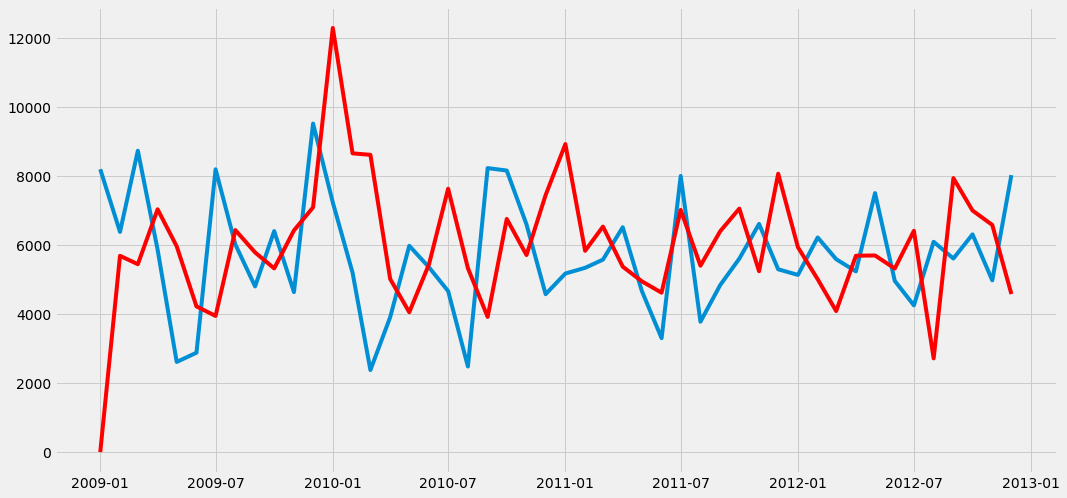

In [82]:

model = sm.tsa.statespace.SARIMAX(tech,order=(1,1,1),seasonal_order=(1,1,0,12),nforce_stationarity=False,
                                enforce_invertibility=False)
results=model.fit()
plt.figure(figsize=(16, 8))
plt.plot(tech)
plt.plot(results.fittedvalues,color='red')
plt.show()

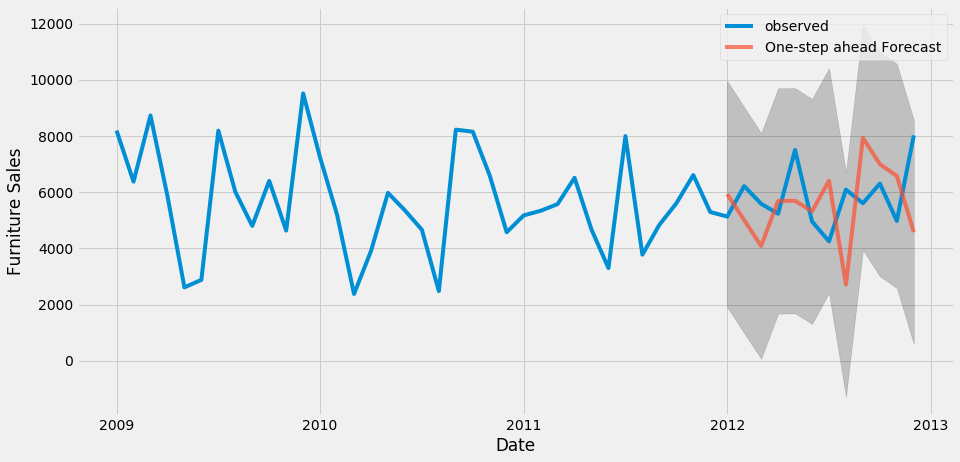

The Mean Squared Error of our forecasts is 3696874.32
The Root Mean Squared Error of our forecasts is 1922.73
Mean absolute percentage err: 27.985868032022964
Daily sales range: 8022.701374999999  to  4250.217675


In [83]:
pred = results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = tech['2009':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()
y_forecasted = pred.predicted_mean
y_truth = tech['2012-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
mape = np.mean(np.abs((y_forecasted - y_truth)/y_truth))*100
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
print('Mean absolute percentage err:',mape)
print('Daily sales range:', tech['2012':].max(),' to ',tech['2012':].min())

It is tricky to build a powerful ARIMA forecasting model because of the noise from trend, season and autocorrelation. 

## Modeling with Prophet

Facebook Prophet was released in 2017 and it is available for python and R. It is designed to do gread job on data with seasonality. And it is robust to tacle missing data and shifts in the trend. It is a good choice for producting forecasts for the supermarket dataset. 

Before using Prophet, I rename the columns to the correct format. The data column must be called 'ds' and the value column we want to predict 'y'. 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

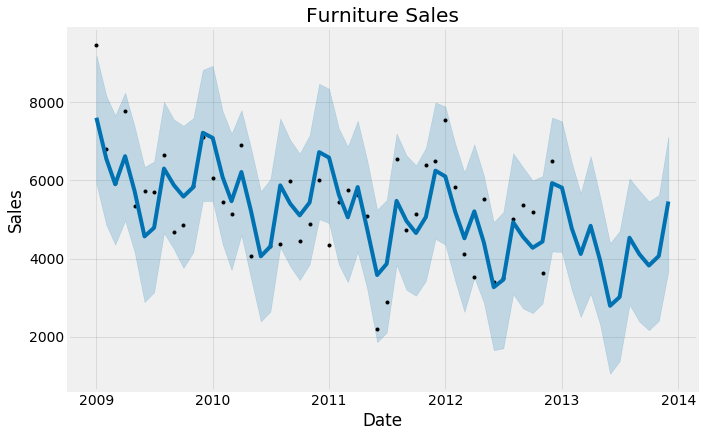

In [84]:
from fbprophet import Prophet
furniture = ts[0]
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

furniture_forecast = furniture_model.make_future_dataframe(periods=12, freq='MS')
# I specify the number fo future periods to predict as one year in my case and the frequency of predictions as monthly. 
furniture_forecast = furniture_model.predict(furniture_forecast)

plt.figure(figsize=(18, 6))

furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

The black dots represent the actual values, the blue line indicates the forecasted values, and the light blue shaded region is the uncertainty.

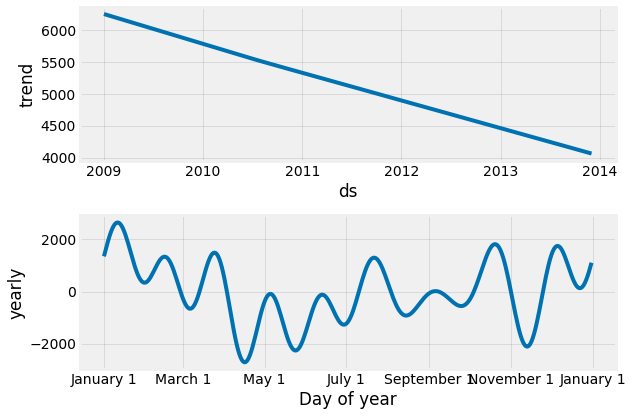

In [85]:
furniture_model.plot_components(furniture_forecast);


The time series predictive mode based on Prophet allows us to visualize the trend and the seasonality of the data for furnature. The yearly pattern is interesting. It seems that there is more sales on January and December. And the worst month is April. Intuitively, this is exactly what we expected to see. During the holiday season, there are always much more promotions and purchase plans are scheduled. 

Looking at the trend, it suggests that the sales for furnature decreases with quickly declining. I think further investigation is needed to try to explain this trend. the US economy was in a deep recession since 2009. And the economy cycle is always between periods of expansion (growth) and contraction (recession). More information and research should be considered for the correlation with the economy. 

## Summary

In this project, I demonstrate two different models to forecast supermarket sales time series.
I handle time series dataset, make a few exploratory plots, create ARMIA and Prophet models and fit to the data. Some parameters are selected to control models' behaviors and predictions. And I also provide evaluation results for models. 